# Capstone project: Financial companies complaints analysis
## Data Analytics with Spark

#### Step 1 - Importing packages

In [7]:
# General:
import pandas as pd
import pandas.io.sql as sqlio
import numpy as np
import os
import re

# Database:
import psycopg2
import keyring
import getpass
import pyspark


# Viz
import matplotlib
import matplotlib.pyplot as plt

# My libraries:
import sys
sys.path.insert(0, '../config')

# Warnings
import warnings; warnings.simplefilter('ignore')

#### Step 2 - Configuration File

In [2]:
import configparser

config = configparser.ConfigParser()
config.read('../config/dwh.cfg')

['../config/dwh.cfg']

In [3]:
config

#### Step 3 - Define Connection to AWS Redshift Database

In [4]:
'''
Database Connection

Requirements: 
    1. AWS Redshift credentials
'''

p = keyring.get_password('redshift', 'user_name')
HOST = config.get('CLUSTER', 'HOST')
DB_NAME =  config.get('CLUSTER', 'DB_NAME')
DB_USER = config.get('CLUSTER', 'DB_USER')
DB_PASSWORD = config.get('CLUSTER', 'DB_PASSWORD')
DB_PORT = config.get('CLUSTER', 'DB_PORT')

a = "user='{}' password='{}' host='{}' port='{}' dbname='{}' ".format(DB_USER, DB_PASSWORD, HOST, DB_PORT, DB_NAME)

#print(a)

try:
    conn = psycopg2.connect(
        "user='{}' password='{}' host='{}' port='{}' dbname='{}' ".format(DB_USER, DB_PASSWORD, HOST, DB_PORT, DB_NAME))

    cursor = conn.cursor()
    print('I am connected to the database!')
except:
    print('I am unable to connect to the database! Please, enter with your credentials.')

I am connected to the database!


In [8]:
# SPARK
sc = pyspark.SparkContext('local[*]')


In [9]:
spark = pyspark.sql.SparkSession \
     .builder \
     .master('local[*]') \
     .appName('Python Spark to Consumer Complaints') \
     .getOrCreate()

#### Step 4 - Extracting data

In [10]:
# read source file
pd_df = pd.read_csv('../data/source/complaints.csv')
pd_df.columns = [col.lower().replace(' ', '_') for col in 
                 pd_df.columns]

# convert in parquet
pd_df.to_parquet('../data/raw/consumer_complaints.parquet')

#### Check tables

In [11]:
df = spark.read.load('../data/raw/consumer_complaints.parquet',
     inferSchema='true', header='true')

In [14]:
df.head()

Row(date_received='2019-09-24', product='Debt collection', sub-product='I do not know', issue='Attempts to collect debt not owed', sub-issue='Debt is not yours', consumer_complaint_narrative='transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.', company_public_response=None, company='TRANSWORLD SYSTEMS INC', state='FL', zip_code='335XX', tags=None, consumer_consent_provided?='Consent provided', submitted_via='Web', date_sent_to_company='2019-09-24', company_response_to_consumer='Closed with explanation', timely_response?='Yes', consumer_disputed?=None, complaint_id=3384392)

#### Analysis

In [20]:
from pyspark.sql.functions import to_date
first_date = df.select(to_date(df.date_received, 'yyyy-MM-dd').alias('date')).orderBy('date').take(1)
first_date

[Row(date=datetime.date(2011, 12, 1))]

In [21]:
last_date = df.select(to_date(df.date_received, 'yyyy-MM-dd').alias('date')).orderBy('date', ascending=False).take(1)
last_date

[Row(date=datetime.date(2021, 3, 26))]

In [22]:
## How many complaints do we have total? Per day?
days = last_date[0]['date']-first_date[0]['date']
df.count()/days.days

594.0170437848957

In [23]:
dates = df.select(to_date(df.date_received, 'yyyy-MM-dd').alias('date'))
complaints_per_day_pd =dates.groupBy('date').count().sort('date').toPandas()

In [25]:
daily_complaint_counts = dates.groupBy('date').count()
daily_complaint_counts.filter(
     daily_complaint_counts['count'] > 3500) \
     .orderBy('date').show()

+----------+-----+
|      date|count|
+----------+-----+
|2017-09-08| 3553|
+----------+-----+



In [ ]:
## Which companies got the most complaints?

In [30]:
company_counts = df.groupBy('company').count()
company_counts_for_graph = company_counts.filter(
     company_counts['count'] >21000) \
     .sort('count', ascending=False).toPandas()

<AxesSubplot:xlabel='company'>

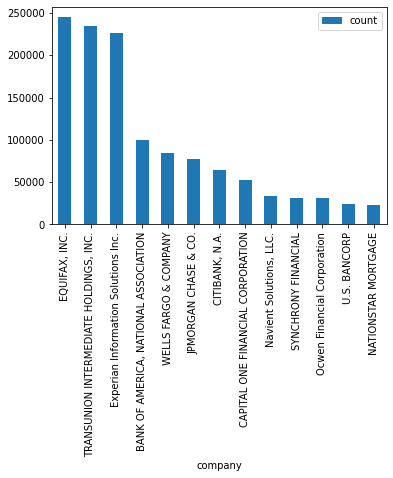

In [31]:
company_counts_for_graph.plot(kind='bar',x='company',y='count')

<AxesSubplot:xlabel='submitted_via'>

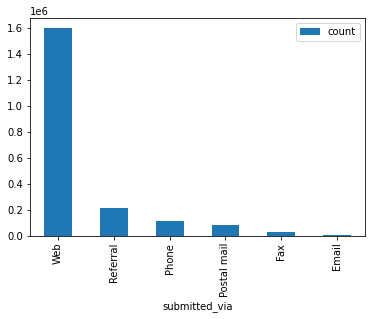

In [37]:
## How are the complaints received? Mostly via the web.
a = df.groupBy('submitted_via').count().sort('count', ascending=False).toPandas()
a.plot(kind='bar',x='submitted_via',y='count')

-----
-----